# Python之ML--模型评估与参数调优

主要知识点如下：
- 模型性能的无偏估计
- 处理机器学习算法常见问题
- 机器学习模型调优
- 使用不同的性能指标评估预测模型

## 一.基于流水线的工作流

本节使用scikit-learn中的Pipline类.它使得我们可以拟合出包含任意多个处理步骤的模型,并将模型用于新数据的预

### 1.威斯康星乳腺癌数据集

威斯康星乳腺癌(Breast Cancer Wisconsin)数据集进行讲解,此数据集共包含了569个恶性或者良性肿瘤样本.数据集的前两列分别存储了样本唯一的ID以及对样本的诊断结果(M代表恶性,B代表良性).数据集的3-32列包含了30个从细胞核照片中提取,用实数值标识的特征,它们可以用于构建判定模型,对肿瘤是良性还是恶性做出预测

使用pandas从UCI网站直接读取数据集

In [1]:
import pandas as pd

df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None)

In [2]:
print('rows, columns:', df.shape)
df.head()

rows, columns: (569, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


接下来,将数据集的30个特征的赋值给一个Numpy的数组对象X.使用scikit-learn中的LabelEncoder类,我们可以将类标从原始的字符串表示(M或者B)转换为整数

In [6]:
from sklearn.preprocessing import LabelEncoder

X=df.loc[:,2:].values
y=df.loc[:,1].values

le=LabelEncoder()
y=le.fit_transform(y)

转换后的类标(诊断结果)存储在一个数组y中,此时恶性肿瘤和良性肿瘤分别被标识为类1和类0,我们通过LabelEncoder的transform方法来显示虚拟类标(0和1)

In [7]:
le.transform(['M','B'])

array([1, 0], dtype=int64)

In [8]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

### 2.在流水线中集成数据转换及评估操作

出于性能优化的目的,许多学习算法要求将不同特征的值缩放到相同的范围.我们在使用逻辑斯谛回归模型等线性分类器分析威斯康星乳腺癌数据集之前,需要对其特征列做标准化处理.我们无需在训练数据集和测试数据集上分别进行模拟拟合,数据转换,而是通过流水线将StandardScaler，PCA以及LogisticRegression对象串联起来：

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr=Pipeline([('scl',StandardScaler()),('pca',PCA(n_components=2)),('clf',LogisticRegression(random_state=1))])

pipe_lr.fit(X_train,y_train)

print('Test Accuracy:%.3f'%pipe_lr.score(X_test,y_test))

Test Accuracy:0.947


E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline对象采用元组的序列作为输入,其中每个元组中的第一个值为一个字符串,它可以是任意的标识符,我们通过它来访问流水线中的元素,而元组的第二个值则为scikit-learn中的一个转换器或者评估器

流水线中包含了scikit-learn中用于数据预处理的类,最后还包括一个评估器.在前面的示例代码中,流水线中有两个预处理环节,分别是用于数据缩放和转换的StandardScaler及PCA,最后还有一个作为评估器的逻辑斯谛回归分类器

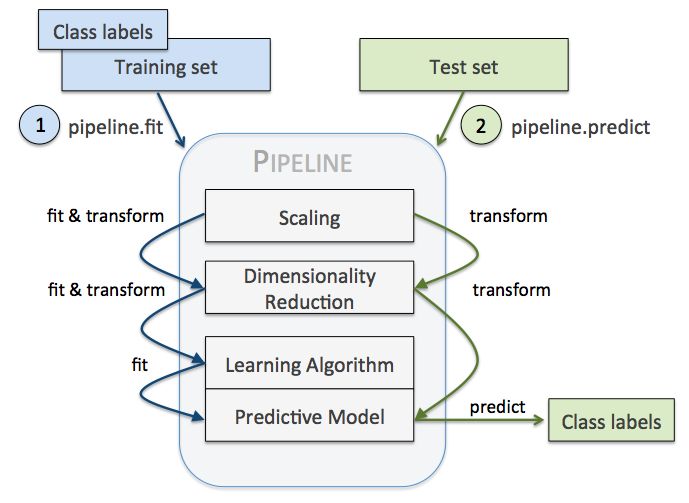

In [10]:
from IPython.display import Image
Image(filename='./data/6/images/06_01.png', width=500) 

## 二.使用k折交叉验证评估模型性能

如果一个模型过于简单,将会面临欠拟合(高偏差)的问题,而模型基于训练数据构造得过于复杂,则会导致过拟合(高方差)问题.交叉验证技术：holdout交叉验证(holdout cross-validation)和k折交叉验证(k-fold cross-validation)

### 1.holdout方法

通过holdout方法,我们将最初的数据集划分为训练数据集和测试数据集：前者用于模型的训练,而后者则用于性能的评估.然而,为了进一步提高模型在预测未知数据上的性能,我们还要对不同参数设置进行调优和比较.该过程称为模型选择(model selection),指的是针对给定问题我们调整参数以寻求最优值(也称为超参,hyperparameter)的过程

使用holdout进行模型选择更好的方法是将数据划分为三个部分：训练数据集,验证数据集和测试数据集

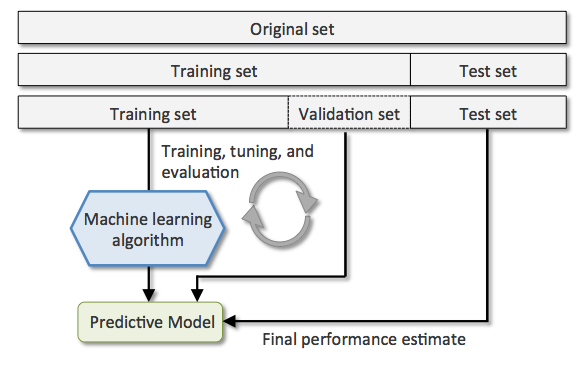

In [11]:
Image(filename='./data/6/images/06_02.png', width=500) 

holdout方法的一个缺点在于：模型性能的评估对训练数据集划分为训练及验证子集的方法是敏感的：评价的结果会随样本的不同而发生变化

### 2.k折交叉验证

在k折交叉验证中,我们不重复地随机将训练数据集划分为k个,其中k-1个用于模型的训练,剩余的1个用于测试.重复此过程k次,我们就得到了k个模型及对模型性能的评价

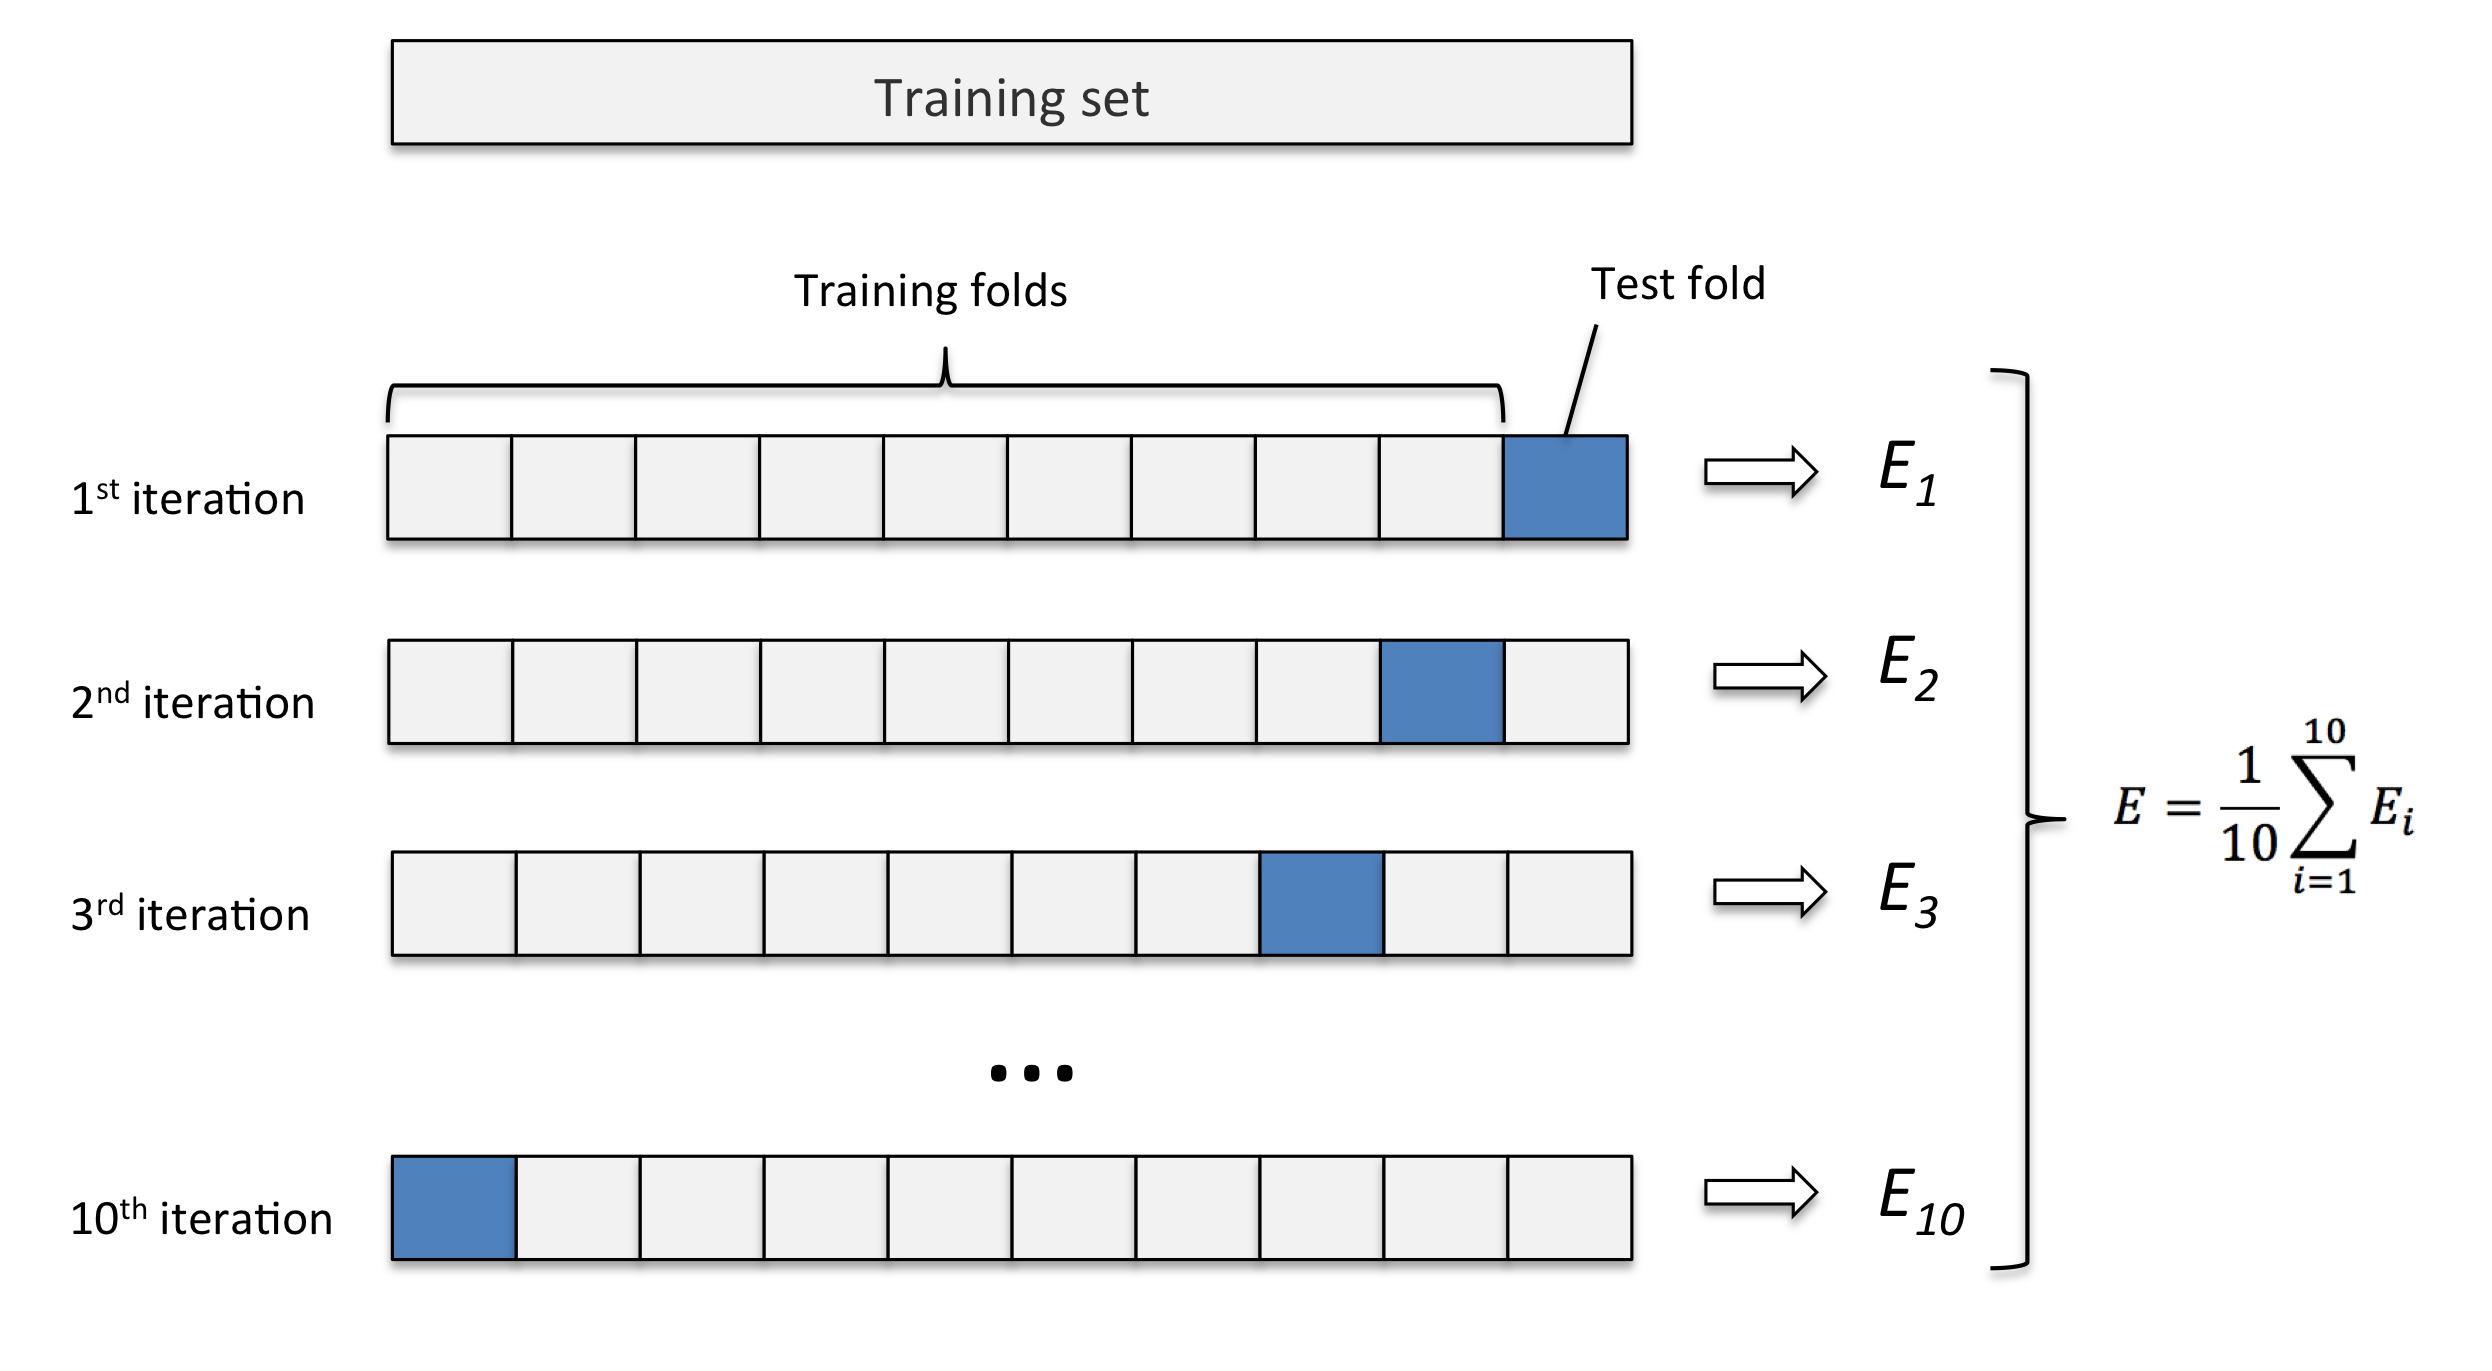

In [12]:
Image(filename='./data/6/images/06_03.png', width=500) 

下面通过scikit-learn中的StratifiedKFold迭代器来演示

In [14]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold=StratifiedKFold(n_splits=10,random_state=1).split(X_train,y_train)

scores=[]

for k,(train,test) in enumerate(kfold):
    pipe_lr.fit(X_train[train],y_train[train])
    score=pipe_lr.score(X_train[test],y_train[test])
    scores.append(score)
    print('Fold:%s,Class dist:%s,Acc:%.3f'%(k+1,np.bincount(y_train[train]),score))

Fold:1,Class dist:[256 153],Acc:0.891
Fold:2,Class dist:[256 153],Acc:0.978
Fold:3,Class dist:[256 153],Acc:0.978
Fold:4,Class dist:[256 153],Acc:0.913
Fold:5,Class dist:[256 153],Acc:0.935
Fold:6,Class dist:[257 153],Acc:0.978
Fold:7,Class dist:[257 153],Acc:0.933
Fold:8,Class dist:[257 153],Acc:0.956
Fold:9,Class dist:[257 153],Acc:0.978
Fold:10,Class dist:[257 153],Acc:0.956


E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

In [15]:
print('CV accuracy:%.3f+/-%.3f'%(np.mean(scores),np.std(scores)))

CV accuracy:0.950+/-0.029


首先,我们用训练集中的类标y_train来初始化sklearn.model_selection模块下的StratifiedKfold迭代器,并通过n_folds参数来设置块的数量.当我们使用kfold迭代器在k个块中进行循环时,使用train中返回的索引去拟合所构建的逻辑斯谛回归流水线,通过pile_lr流水线,我们可以保证每次迭代中样本都得到适当的缩放(如标准化).然后使用test索引计算模型的准确率,将其存储在score列表中,用于计算平均准确率以及性能评估标准差

使用分层k折交叉验证对模型进行评估

In [16]:
from sklearn.model_selection import cross_val_score

scores=cross_val_score(estimator=pipe_lr,X=X_train,y=y_train,cv=10,n_jobs=-1)

print('CV accuracy scores:%s'%scores)

CV accuracy scores:[0.89130435 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]


In [17]:
print('CV accuracy:%.3f+/-%.3f'%(np.mean(scores),np.std(scores)))

CV accuracy:0.950+/-0.029


cross_val_score方法具备一个较为有用的特点,它可以将不同分块的性能评估分布到多个CPU上进行处理

## 三.通过学习及验证曲线来调试算法

两个提高学习算法性能的简单但功能强大的判定工具：学习曲线(learning curve)与验证曲线(validation curve)

### 1.使用学习曲线判定偏差和方差问题

我们先通过下图来讨论一个模型常见的两个问题：

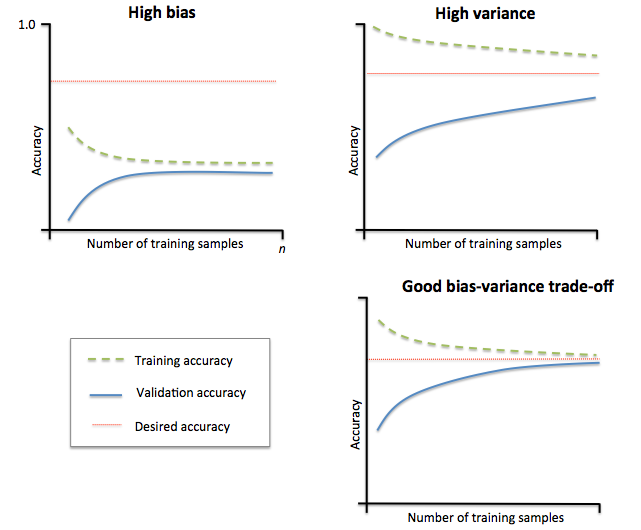

In [18]:
Image(filename='./data/6/images/06_04.png', width=500) 

左上图图像显示的是一个高偏差模型.此模型的训练准确率和交叉验证准确率都很低,这表明此模型未能很好地拟合数据.解决此问题的常用方法是增加模型中的参数的数量,例如收集或构建额外特征,或者降低类似于SVM和逻辑斯谛回归器等模型的正则化程度.右上图图像中的模型面临高方差的问题,表明训练准确度与交叉验证准确度之间有很大差距,针对此类过拟合问题,我们可以收集更多的训练数据或者降低模型的复杂度,如增加正则化的参数

看一下如何使用scikit-learn中的学习曲线函数评估模型

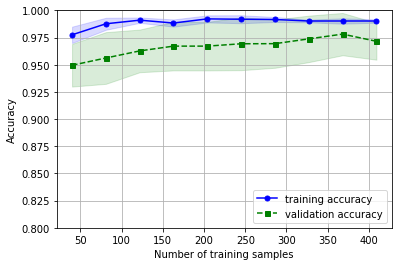

In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr=Pipeline([
    ('scl',StandardScaler()),
    ('clf',LogisticRegression(penalty='l1',random_state=0))
    
])

train_sizes,train_scores,test_scores=learning_curve(estimator=pipe_lr,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=-1)

train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)

plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')

plt.plot(train_sizes,test_mean,color='green',linestyle='--',marker='s',markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')
plt.ylim([0.8,1.0])

plt.show()

通过learning_curve函数的train_size参数,我们可以控制用于生成学习曲线的样本的绝对或相对数量.通过设置train_sizes=np.linspace(0.1,1.0,10)来使用训练数据集上等距间隔的10个样本.默认情况下,learning_curve函数使用分层k折交叉验证来计算交叉验证的准确性,通过cv参数将k的值设置为10.在绘制图像时,我们通过fill_between函数加入了平均准确率标准差的信息,用以表示评价结果的方差

### 2.通过验证曲线来判定过拟合与欠拟合

逻辑斯谛回归模型中的正则化参数C.使用scikit-learn来绘制验证曲线

E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

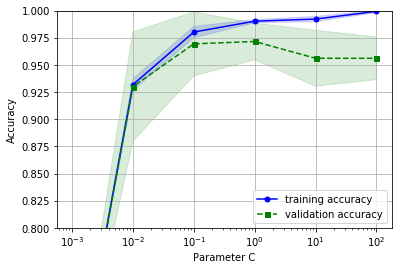

In [21]:
from sklearn.model_selection import validation_curve

param_range=[0.001,0.01,0.1,1.0,10.0,100.0]

train_scores,test_scores=validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='clf__C',
    param_range=param_range,
    cv=10
)

train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)

plt.plot(param_range,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')

plt.plot(param_range,test_mean,color='green',linestyle='--',marker='s',markersize=5,label='validation accuracy')
plt.fill_between(param_range,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')
plt.ylim([0.8,1.0])

plt.show()

虽然不同C值之间准确率的差异非常小,但我们可以看到,如果加大正则化强度(较小的C值),会导致模型轻微的欠拟合;如果增加C的值,这意味着降低正则化的强度,因此模型会趋于过拟合.最优点在C=0.1

## 四.使用网格搜索调优机器学习模型

在机器学习中,有两类参数：通过训练数据学习得到的参数,如逻辑斯谛回归中的回归系数;以及学习算法中需要单独进行优化的参数.后者即为调优参数,也称为超参,对模型来说,就如逻辑斯谛回归中的正则化系数,或者决策树中的深度参数

接下来学习一种功能强大的超参数优化技巧：网格搜索(grid search),它通过寻找最优的超参值的组合以进一步提高模型的性能

### 1.使用网格搜索调优超参

网格搜索法非常简单,它通过对我们指定的不同超参列表进行暴力穷举搜索,并计算评估每个组合对模型性能的影响,以获得参数的最优组合

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc=Pipeline([('scl',StandardScaler()),('clf',SVC(random_state=1))])

param_range=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]

param_grid=[{'clf__C':param_range,'clf__kernel':['linear']},
           {'clf__C':param_range,'clf__gamma':param_range,'clf__kernel':['rbf']}]

gs=GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',cv=10,n_jobs=-1)

gs=gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978021978
{'clf__C': 0.1, 'clf__kernel': 'linear'}


E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


我们将GridSearchCV的param_grid参数以字典的方式定义为待调优的参数,通过best_score属性得到最优模型的性能评分,具体参数信息可通过best_params_属性获得

最后,我们将使用独立的测试数据集,通过GridSearchCV对象的best_estimator_属性对最优模型进行性能评估

In [34]:
clf=gs.best_estimator_
clf.fit(X_train,y_train)

print('Test accuracy:%.3f'%clf.score(X_test,y_test))

Test accuracy:0.965


### 2.通过嵌套交叉验证选择算法

在嵌套交叉验证的外围循环中,我们将数据划分为训练块及测试块;而在用于模型选择的内部循环中,我们则基于这些训练块使用k折交叉验证.在完成模型的选择后,测试模块用于模型性能的评估

下图通过5个外围模块及2个内部模块解释嵌套交叉验证的概念

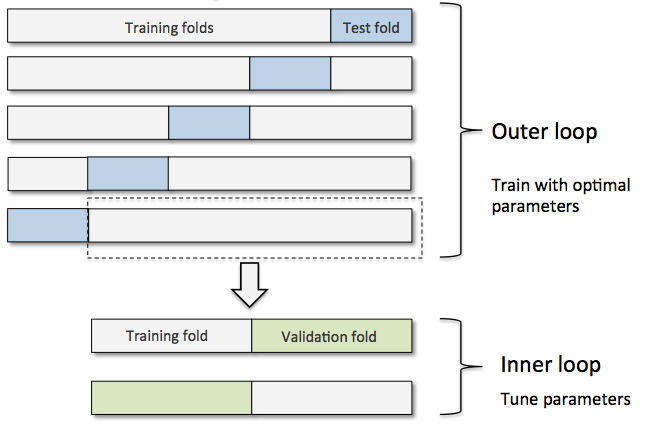

In [24]:
Image(filename='./data/6/images/06_07.png', width=500) 

通过如下方式使用嵌套交叉验证

In [35]:
gs=GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',cv=10,n_jobs=-1)

scores=cross_val_score(gs,X,y,scoring='accuracy',cv=5)

print('CV accuracy:%.3f+/-%.3f'%(np.mean(scores),np.std(scores)))

E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\model_selection\_search

CV accuracy:0.972+/-0.012


E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


我们使用嵌套交叉验证方法比较SVM模型与简单的决策树分类器;为了简单起见,我们只调优树的深度参数

In [37]:
from sklearn.tree import DecisionTreeClassifier

gs=GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=[{'max_depth':[1,2,3,4,5,6,7,None]}],
    scoring='accuracy',
    cv=5
)

scores=cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)

print('CV accuracy:%.3f+/-%.3f'%(np.mean(scores),np.std(scores)))

E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CV accuracy:0.908+/-0.045


E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


在此可见：嵌套交叉验证对SVM模型性能的评分(97.8%)远高于决策树的(90.8%).由此,可以预期：SVM是用于对此数据集未知数据进行分类的一个好的选择

## 五.不同的性能评价指标

准确率(precision),召回率(recall)以及F1分数(F1-score)

### 1.读取混淆矩阵

先绘制一个所谓的混淆矩阵(confusion matrix)：即展示学习算法性能的一种矩阵.混淆矩阵是一个简单的方阵,用于展示一个分类器预测结果--真正(true positive),真负(true negative),假正(false positive)及假负(false negative)--的数量

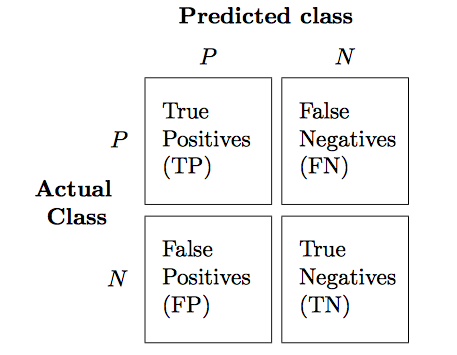

In [25]:
Image(filename='./data/6/images/06_08.png', width=500) 

虽然这指标的数据可以通过人工比较真实类标与预测类标来获得,不过scikit-learn提供了一个方便使用的confusion_matrix函数,其使用方法如下：

In [38]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train,y_train)

y_pred=pipe_svc.predict(X_test)

confmat=confusion_matrix(y_true=y_test,y_pred=y_pred)

print(confmat)

[[71  1]
 [ 2 40]]


使用matplotlib中的matshow函数将它们表示出上图所示的混淆矩阵形式

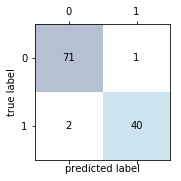

In [40]:
fig,ax=plt.subplots(figsize=(2.5,2.5))

ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
        
plt.xlabel('predicted label')
plt.ylabel('true label')

plt.show()

在本例中,假定类别1(恶性)为正类,模型正确地预测了71个属于类别0的样本(真负),以及40个属于类别1的样本(真正).不过我们的模型也错误地将两个属于类别0的样本划分到了类别1(假负),另外还将一个恶性肿瘤误判为良性的(假正)

### 2.优化分类模型的准确率和召回率

预测误差(error,ERR)和准确率(accuracy,ACC)都提供了误分类样本数量的相关信息.误差可以理解为预测错误样本的数量与所有被预测样本数量的比值,而准确率计算方法则是正确预测样本的数量与所有被预测样本数量的比值：
ERR=\frac{FP+FN}{FP+FN+TP+TN}

预测准确率也可以通过误差直接计算：
ACC=\frac{TP+TN}{FP+FN+TP+TN}=1-ERR

对于类别数量不均衡的分类问题来说,真正率(TPR)与假正率(FPR)是非常有用的性能指标：
FPR=\frac{FP}{N}=\frac{FP}{FP+TN}
TPR=\frac{TP}{P}=\frac{TP}{FN+TP}

准确率(precision,PRE)和召回率(recall,REC)是与真正率,真负率相关的性能评价指标,实际上,召回率与真正率含义相同：
PRE=\frac{TP}{TP+FP}
REC=TPR=\frac{TP}{P}=\frac{TP}{FN+TP}

所有这些评分指标均以在scikit-learn中实现,可以从sklearn.metric模块中导入使用

In [41]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,f1_score

print('Precision:%.3f'%precision_score(y_true=y_test,y_pred=y_pred))
print('Recall:%.3f'%recall_score(y_true=y_test,y_pred=y_pred))
print('F1:%.3f'%f1_score(y_true=y_test,y_pred=y_pred))

Precision:0.976
Recall:0.952
F1:0.964


### 3.绘制ROC曲线

受试者工作特征曲线(receiver operator characteristic,ROC)是基于模型假正率和真正率等性能指标进行分类模型选择的有用工具,假正率和真正率可以通过移动分类器的分类阈值来计算.基于ROC曲线,我们就可以计算所谓的ROC线下区域(area under the curve,AUC),用来刻画分类模型的性能

我们将StratifiedKFold验证器中的分块数量减少为3

E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


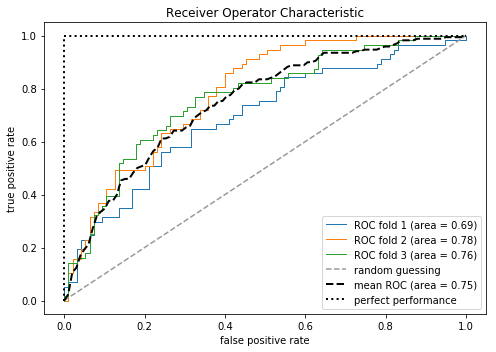

In [43]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])

X_train2 = X_train[:, [4, 14]]

cv = list(StratifiedKFold(n_splits=3,random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

分类器在只有两个特征的训练集上完成拟合后,使用如下代码计算分类器在单独测试集上的ROC AUC得分

In [44]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_labels = pipe_lr.predict(X_test[:, [4, 14]])
y_probas = pipe_lr.predict_proba(X_test[:, [4, 14]])[:, 1]

E:\Anaconda\envs\mytensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [45]:
from sklearn.metrics import roc_auc_score, accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_probas))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_labels))

ROC AUC: 0.752
Accuracy: 0.711
